In [2]:
import numpy as np
import pickle
from numpy.linalg import norm


In [5]:
import os
print(os.listdir("."))
train_r = pickle.load(open("train_r.pkl", "rb"))
train_b = pickle.load(open("train_b.pkl", "rb"))
valid_r = pickle.load(open("valid_r.pkl", "rb"))
valid_b = pickle.load(open("valid_b.pkl", "rb"))
test_r = pickle.load(open("test_r.pkl", "rb"))
test_b = pickle.load(open("test_b.pkl", "rb"))

['train_b.pkl', 'CreateData.ipynb', 'train.pkl', 'Bonus.ipynb', 'valid_b.pkl', 'clean_real.txt', 'NativeBayes.ipynb', 'test_b.pkl', 'train_r.pkl', 'SklearnTrees.ipynb', 'CreateData.py', 'XGB_bonus.ipynb', 'test_r.pkl', 'train.pickle', 'clean_fake.txt', '__pycache__', 'LogisticRegression.ipynb', 'valid.pkl', 'pics', 'tree.dot', 'NativeBayes.py', 'valid_r.pkl', 'fake.py', '.ipynb_checkpoints', 'LogisticRegression.py', 'bonus_spacy.ipynb', 'bonus_pics', 'test.pkl']


In [6]:
print(valid_r[:3])

['trump and trade richardson every', 'trump charlottesville condemnation included neo nazis whitehouse', 'hameed darweesh iraqi refugee detained at jfk after trump order']


In [7]:
one_label = np.ones(len(train_r))
zeros_label = np.zeros(len(train_b))
one_test = np.ones(len(valid_r))
zero_test = np.zeros(len(valid_b))
trainX = np.concatenate((train_r, train_b))
trainY = np.concatenate((one_label, zeros_label))
validX = np.concatenate((valid_r, valid_b))
validY  = np.concatenate((one_test, zero_test))
print(validX[:3], len(validX))

['trump and trade richardson every'
 'trump charlottesville condemnation included neo nazis whitehouse'
 'hameed darweesh iraqi refugee detained at jfk after trump order'] 490


In [8]:
#gerenate feature vectors 
total_words = {}
for line in trainX:
    words = line.split(" ")
    for word in words:
        if word == "":
            continue
        try:
            total_words[word]
        except:
            total_words[word] = True

print(len(total_words.keys()))
#dont add words in valid and test sets

4818


In [9]:
#create training feats

#print(len(validX))
unique_keys = list(total_words.keys())
unique_keys.sort()
#print(unique_keys[:10])
#account for a bias
train_feats = np.zeros((len(trainX), len(total_words.keys()) ))
for i, line in enumerate(trainX):
    words = line.split(" ")
    #print(words)
    for word in words:
        if word =="":
            continue
        #print(unique_keys.index(word))
        ind = unique_keys.index(word)  
        #plus one is so that the very first is the bias (here a bias of zero)
        train_feats[i][ind] = 1


#create testing features
valid_feats = np.zeros((len(validX), len(total_words.keys())))
for i , line in enumerate(validX):
    words = line.split(" ")
    #print(len(words), end = " ")
    #if i ==0:
        #print(words)
    #print(words)
    for word in words:
        if word =="":
            continue
        #account for value error:
        try:
            ind = unique_keys.index(word) 
            #print(ind)
            valid_feats[i][ind] = 1
        except:
            continue       
#inds = np.where(valid_feats ==1)[1]
#print("\n", inds[:34])

In [10]:
#logistic regression model from assignment 1.
def grad_descent(f, df, x, y, reg, init_t, alpha, EPS=1e-4):
    print(reg)
    #EPS = 1e-4   #EPS = 10**(-5)
    prev_t = init_t-10*EPS
    t = init_t.copy()
    max_iter = 300
    iter  = 0
    while norm(t - prev_t) >  EPS and iter < max_iter:
        prev_t = t.copy()
        t -= alpha*df(x, y, t, reg)
        if iter % 50 == 0:
            print("Iter", iter)
        iter += 1
    print("Iter", iter)
    return t

In [11]:
def softmax(x):
    return 1./(1+np.exp(-1*x))
#assume here that x is already flattened
def f_log(x, y, theta, reg):
    bias = np.ones( (1, x.shape[0])).T
    x = np.vstack( (bias.T, x.T))
    val = softmax(np.dot(theta.T, x))
    vals =  np.sum((y - np.log(val)) - (1.-y)*np.log(1-val)) + reg*np.sum(theta**2)
    return vals
    
def df_log(x, y, theta ,reg):
    bias = np.ones( (1, x.shape[0])).T
    x = np.vstack( (bias.T, x.T))
    val = softmax(np.dot(theta.T, x)) - y
    val = np.dot(val, x.T)
    val += 2.*reg*theta
    return val
    #return   -2*np.sum((y-np.dot(theta.T, x))*x, 1) + 2.*reg*theta

In [12]:
#assume here that x is already flattened
def f_l1(x, y, theta, reg):
    bias = np.ones( (1, x.shape[0])).T
    x = np.vstack( (bias.T, x.T))
    val = softmax(np.dot(theta.T, x))
    vals =  np.sum((y - np.log(val)) - (1.-y)*np.log(1-val)) + reg*np.sum(theta)
    return vals 

def df_l1(x, y, theta ,reg):
    bias = np.ones( (1, x.shape[0])).T
    x = np.vstack( (bias.T, x.T))
    val = softmax(np.dot(theta.T, x)) - y
    val = np.dot(val, x.T)
    val += reg
    return val

In [13]:
np.random.seed(0)
#this is used to create the two differentn types of images, uncomment the one that you dont want
theta0 = np.random.random((len(unique_keys)+1))*5
theta0 = np.ones_like(theta0)

In [14]:
%%time
theta = grad_descent(f_log, df_log, train_feats, trainY,0.15,  theta0, 0.0005, EPS=5e-4)

0.15
Iter 0
Iter 50
Iter 100
Iter 150
Iter 200
Iter 250
Iter 300
CPU times: user 32.4 s, sys: 23.9 s, total: 56.3 s
Wall time: 14.5 s


In [78]:
#learning curve
valid_data_ones = np.concatenate((np.ones((1, valid_feats.shape[0])).T, valid_feats), axis = 1)
preds = np.dot( valid_data_ones, theta)
print(valid_data_ones.shape, theta.shape, preds.shape)
preds_binary= np.zeros_like(preds)
#preds_binary[preds<0.5] = 0
preds_binary[preds>0.5] = 1
#print(preds)
print(len(np.where(validY ==preds_binary)[0]), validY.shape[0])
print(len(np.where(validY ==preds_binary)[0])/ validY.shape[0])
#print(validY)

(490, 4819) (4819,) (490,)
330 490
0.673469387755102


In [15]:
#l2error function

#logistic regression model from assignment 1.
def track_grad_descent(f, df, x, y,reg, init_t, alpha, EPS=1e-4):
    #EPS = 1e-4   #EPS = 10**(-5)
    prev_t = init_t-10*EPS
    t = init_t.copy()
    #times = np.linspace()
    max_iter = 2500
    iter  = 0
    thresh = 25
    iterations = np.arange(max_iter//thresh +1)*thresh
    learn_train = [0]#np.zeros_like(iterations)
    learn_valid = [0]#np.zeros_like(iterations)
    counter = 1
    while norm(t - prev_t) >  EPS and iter < max_iter:
        prev_t = t.copy()
        t -= alpha*df(x, y, t, reg)
        if iter % 500 == 0:
            print("Iter", iter)
        if (iter%thresh==thresh-1):
            #train scores
            train_data_ones = np.concatenate((np.ones((1, train_feats.shape[0])).T, train_feats), axis = 1)
            preds = np.dot(train_data_ones, prev_t)
            preds_binary= np.zeros_like(preds)
            preds_binary[preds<0.5] = 0
            preds_binary[preds>0.5] = 1
            val = len(np.where(trainY ==preds_binary)[0])/ float(trainY.shape[0])
            print(val)

            learn_train.append(val)

            valid_data_ones = np.concatenate((np.ones((1, valid_feats.shape[0])).T, valid_feats), axis = 1)
            preds = np.dot( valid_data_ones, prev_t)
            preds_binary= np.zeros_like(preds)
            preds_binary[preds<0.5] = 0
            preds_binary[preds>0.5] = 1
            val =len(np.where(validY ==preds_binary)[0])/ float(validY.shape[0])
            print(val)
            learn_valid.append(val)
            #learn_valid[counter] = val
            #print(learn_valid)
            #counter +=1
            
        iter += 1
    print(learn_train, learn_valid)
    print("Iter", iter)
    return t, learn_train, learn_valid

In [94]:
#%%time
#done with l2 regularization
np.random.seed(0)
theta0 = np.random.random((len(unique_keys)+1))
theta, train_learn, valid_learn = track_grad_descent(f_log, df_log, train_feats, trainY, 5, theta0, 0.0005, EPS=5e-4)

Iter 0
0.49934411893310016
0.5183673469387755
0.6156536947966769
0.6224489795918368
0.6724967205946655
0.6755102040816326
0.7153476169654569
0.7061224489795919
0.7485789243550502
0.7346938775510204
0.7756886751202449
0.7591836734693878
0.7931788369042414
0.7673469387755102
0.8067337122868387
0.7836734693877551
0.8159160472234368
0.7877551020408163
0.8229121119370354
0.7979591836734694
0.8334062090074333
0.8
0.839965019676432
0.8061224489795918
0.8456493222562309
0.8081632653061225
0.8495846086576301
0.810204081632653
0.8539571491036292
0.8163265306122449
0.8561434193266287
0.8224489795918367
0.8578924355050285
0.8244897959183674
0.8618277219064276
0.826530612244898
0.8653257542632269
0.8244897959183674
0.8662002623524268
0.8244897959183674
Iter 500
0.8675120244862266
0.8244897959183674
0.8692610406646262
0.8244897959183674
0.8710100568430258
0.8244897959183674
0.8710100568430258
0.8244897959183674
0.8710100568430258
0.8244897959183674
0.8718845649322257
0.8244897959183674
0.87232181897

In [98]:
import matplotlib
from matplotlib import pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
#matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **font)

/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


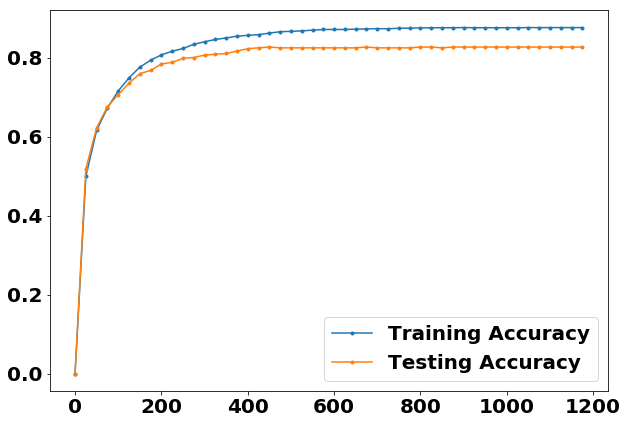

In [101]:
iterations = np.arange(1176//25 +1)*25


plt.figure(figsize = (10, 7))
plt.plot(iterations, train_learn, marker = ".", label = "Training Accuracy")
plt.plot(iterations, valid_learn, marker = ".", label = "Testing Accuracy")

plt.legend()
plt.show()
#print(train_learn)

In [102]:
#%%time
#done with l1 regularization
np.random.seed(0)
theta0 = np.random.random((len(unique_keys)+1))
theta, train_learn, valid_learn = track_grad_descent(f_l1, df_l1, train_feats, trainY, 5, theta0, 0.0005, EPS=5e-4)

Iter 0
0.5080891998250984
0.5224489795918368
0.630083078268474
0.6510204081632653
0.6987319632706602
0.6959183673469388
0.7538259728902492
0.7387755102040816
0.7870572802798426
0.773469387755102
0.8045474420638391
0.8040816326530612
0.8264101442938347
0.8142857142857143
0.8390905115872321
0.8224489795918367
0.8574551814604285
0.8326530612244898
0.8648885002186271
0.8387755102040816
0.8688237866200262
0.8346938775510204
0.8736335811106253
0.8367346938775511
0.8762571053782248
0.8448979591836735
0.8753825972890249
0.8510204081632653
0.8775688675120245
0.8510204081632653
0.8823786620026235
0.8551020408163266
0.8806296458242239
0.8591836734693877
0.8801923917796239
0.8591836734693877
0.8780061215566244
0.8551020408163266
0.8788806296458243
0.8591836734693877
Iter 500
0.8801923917796239
0.8591836734693877
0.8801923917796239
0.8591836734693877
0.8788806296458243
0.8551020408163266
0.8784433756012243
0.8591836734693877
0.8784433756012243
0.863265306122449
0.8775688675120245
0.863265306122449


/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


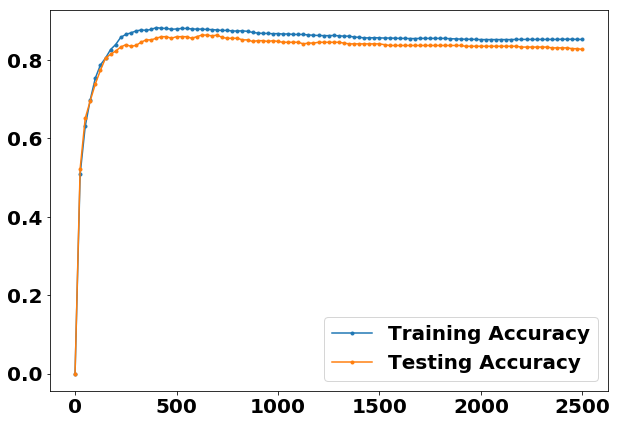

In [103]:
iterations = np.arange(2500//25 +1)*25


plt.figure(figsize = (10, 7))
plt.plot(iterations, train_learn, marker = ".", label = "Training Accuracy")
plt.plot(iterations, valid_learn, marker = ".", label = "Testing Accuracy")

plt.legend()
plt.show()
#print(train_learn)

#write up part 5

Its reasonable to use magnitude for this, since the different scale for the features have meaning, if one is larger, it means that it occured more often(native bayes method)
For this one, the individual features are already normalized, since they're either zero if that word is not present, or are one if they are. 